# Granite intrusion

The following is an example of the thermal decay of a near-surface granite intrusion, as presented in C Fowler's "The Solid Earth". 

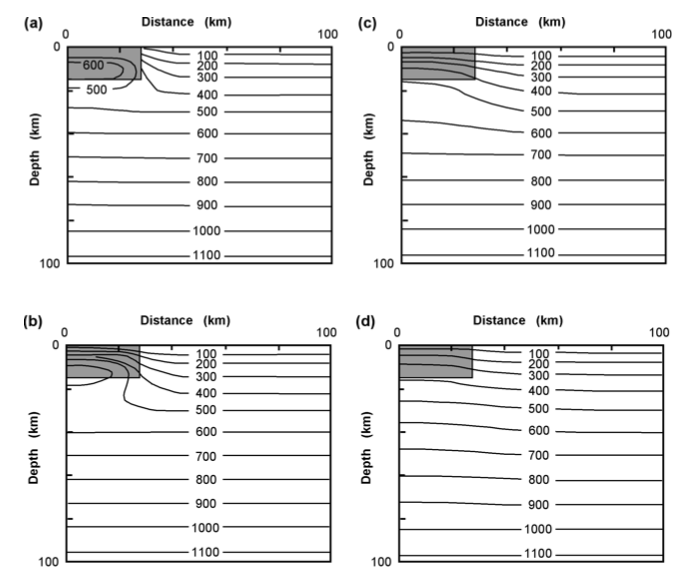
<br>
The original figure comes from Fowler and Nisbet (1982). In the top left is a large (rectangular) granite body, which intruded with an initial temperature of 700 ◦ C. The panels are for (a) 1 Ma, (b) 2 Ma and (c) 5 Ma and (d) 20 Ma after intrusion.

The high heat production in the granite keeps the local temperatures in and around it elevated. Fowler gives the granite a heat production of 4.2 $\mu$ W m<sup>−3</sup>. Curiously, they also employ a latent heat of crystallization of 4.2 × 10<sup>5</sup> J kg<sup>−1</sup>, which is released over 2 Ma. Note the units.

We're going to deviate from the example and just consider a high-heat production granite, and leave the implementation of a second time-decaying source for a rainy day. 


We first import the required libraries:

In [46]:
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

Next we import the planet_LB library, and create an object:

In [47]:
import planet_LB as p_LB

M2S = p_LB.Myr2s
Y2S = M2S/1e6
pLB = p_LB.planet_LB()


100 lattice cells are used in both the vertical and horizontal directions (m and n), and the extent of the cell is 1.0 in both x and y. The lattice spacing is then distance/m, etc.

There are source terms in this problem (H, is the heat production divided by the thermal capacity C<sub>p</sub>), the timestep is set to 25 years, and the total number of timesteps is calculate from dt and requested simulation time (here called "age"). We initialise the problem with a value for the total timesteps of 40,000, but note we walk all over that. Again, the thermal diffusivity (here called kappa) is set to 1e-6, which is appropriate for geological materials.

In [48]:

T_top=0.0 # Left hand wall temperature - seems like bottom, ie. i=0 is bottom

T_base=1125.0

m=100
n=100

dist_x = 1.0e5  #100km
dist_y = 1.0e5
# Backing out increments
dx = dist_x/n
dy= dist_y/m

H=0

dt=25.0 * Y2S # Timesteps of 25 years (in sec)
kappa=1e-6 # Thermal diffusivity
mstep=40000 #40000



We now call the initialisation routine for the problem. The following initialisation routine is specific to this benchmark, and creates the grid, etc as a dictionary object, which may be passed to the D2Q9 solver.

We haven't configured the thermal field or anything yet (we'll do that below), but we need the grid positions to allocate temperatures and internal heating to - so we call LB_D2Q9_init_ThermStruct first here:

In [49]:
lb_s = pLB.LB_D2Q9_init_ThermStruct(dt,m,n,dx,dy,T_base,H,kappa,mstep)

We now set up the initial thermal field. We impose a linear temperature gradient between the base of the model (1125 C at 100km), and the surface (set at 0C). We then impose a zone of hot granite between 0->27km in the x direction, and 0->10km depth in the y direction.  

Note the granite heat production is 4.2 $\mu$ W m<sup>−3</sup>. We want this in W/kg - so we divide by the density of granite (~2600 kg/m<sup>3</sup>). Thus H=1.615e-9. Note that this gets divided by the thermal capacitance (C<sub>p</sub> = 1000) in the source term below.

(Note from Turcutte and Schubert, 1982 -  a typical value for a granite is Hc = 9.6 × 10<sup>−10</sup> W kg<sup>−1</sup>).

Shape, 2: (101, 101)


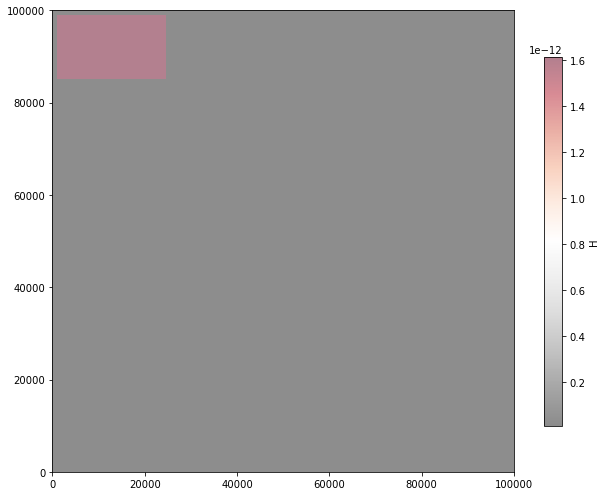

In [50]:
T = np.ones_like(lb_s['T'])
X = lb_s['x']
Y = lb_s['y']

H = np.ones_like(T)*1e-11/1000


#Impose initial linear gradient on Temp field
T1 = np.linspace(T_base,T_top,m+1)
for j in np.arange(0,m+1,1):
    T[:,j] = T[:,j]*T1[j]
print("Shape, 2:",np.shape(T))

# Create block intrusion at x=20km,y=10km
for j in np.arange(0,m+1,1):
    for i in np.arange(0,n+1,1):
        if X[i,j] > 0. and X[i,j] < 25000.0:
            if Y[i,j] > 85000.0 and Y[i,j] < 100000:
                T[i,j] = 700
                H[i,j] = 1.615e-9/1000  # H/Cp is the source term S for the heat equation in LB
T_init = T
lb_s['T'] = T
lb_s['H'] = H
lb_s['T_top'] = T_top
lb_s['T_base'] = T_base
plt.figure(figsize=(9,7))
plt.imshow(H.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
cbar=plt.colorbar(label='H',shrink=0.8);
plt.tight_layout()

We can view our initial thermal field

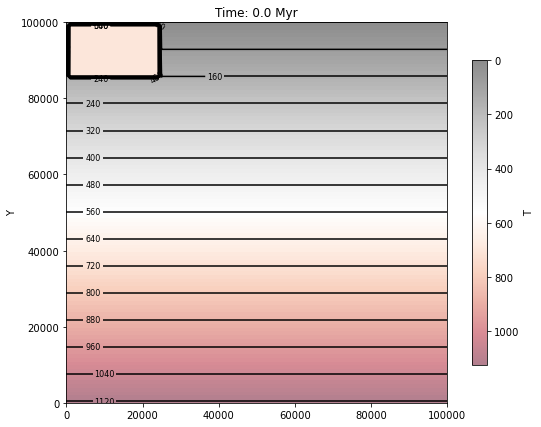

In [51]:
plt.figure(figsize=(9,7))
plt.tight_layout()

#plt.subplot(2,2,1)
con1 = plt.contour(X,Y,T,15,colors='black')
plt.clabel(con1,inline=True,fontsize=8)
plt.ylabel("Y")
plt.title("Time: {} Myr".format(0.0))
plt.imshow(T.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
#plt.colorbar();
cbar=plt.colorbar(label='T',shrink=0.8);
cbar.ax.invert_yaxis() 


## Runing the simulation for 1 Myr
We will now run the simulation for 1 Myr. Note we preserve the preset timestep inour simulation, and run for longer times by increasing the number of timesteps, mstep. So - if we force the simulation to run for 1 Myr, we must update our mstep in the structure. The following view our initial thermal field

In [52]:
# Note that omega in our structure contains our information about timestep (which depends on simulation time)

age=1.0 #Myr
lb_s = pLB.update_time(age,lb_s)
print(lb_s['mstep'])

40000


In [53]:
mstep=lb_s['mstep']

timesteps = dt*np.arange(1,mstep+1,1)
for t in timesteps:
    lb_s['T']=T
    lb_s['f']=f
    lb_s =  pLB.LB_D2Q9_T(lb_s)
    T=lb_s['T']
    f=lb_s['f']
    
print(T)

[[1.12500002e+03 1.10859839e+03 1.09216078e+03 ... 2.75711677e+02
  1.41675924e+02 1.78351776e-05]
 [1.12500002e+03 1.10859839e+03 1.09216078e+03 ... 2.75711677e+02
  1.41675924e+02 1.78351776e-05]
 [1.12500002e+03 1.10859879e+03 1.09216149e+03 ... 2.75676334e+02
  1.41658776e+02 1.78351776e-05]
 ...
 [1.12500002e+03 1.10967165e+03 1.09430690e+03 ... 1.39763833e+01
  7.00615346e+00 1.78351776e-05]
 [1.12500002e+03 1.10967162e+03 1.09430719e+03 ... 1.39771997e+01
  7.00661613e+00 1.78351776e-05]
 [1.12500002e+03 1.10967162e+03 1.09430719e+03 ... 1.39771997e+01
  7.00661613e+00 1.78351776e-05]]


The final temperature after 200,000 timesteps is T. Note that f is updated during the loop as well.  Note we haven't archived the intermediate steps here. We can view the thermal field with the following.

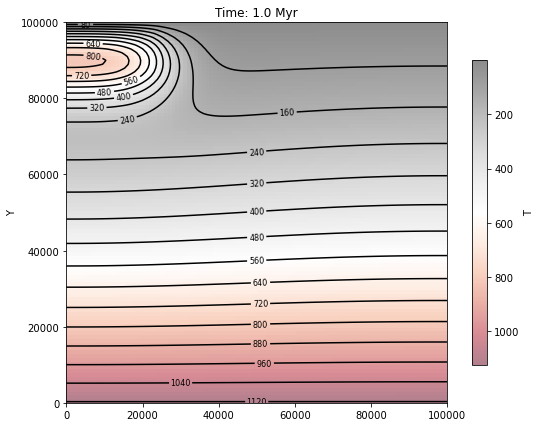

In [55]:
plt.figure(figsize=(9,7))
plt.tight_layout()

#plt.subplot(2,2,1)
con1 = plt.contour(X,Y,T,15,colors='black')
plt.clabel(con1,inline=True,fontsize=8)
plt.ylabel("Y")
plt.title("Time: {} Myr".format(age))
plt.imshow(T.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
#plt.colorbar();
cbar=plt.colorbar(label='T',shrink=0.8);
cbar.ax.invert_yaxis() 

The data may be saved for future use with the following.

In [15]:
np.savez("benchmark_granite.npz",X=X,Y=Y,T=T)

In [56]:
npzfile = np.load("benchmark_granite.npz")

## 5 Myr of cooling
We now update the age to 5 Myr (post-intrusion).  Since our total run is longer, we also must increase the total timesteps (mstep), which we do by using our bespoke routine "update_time". 

200000


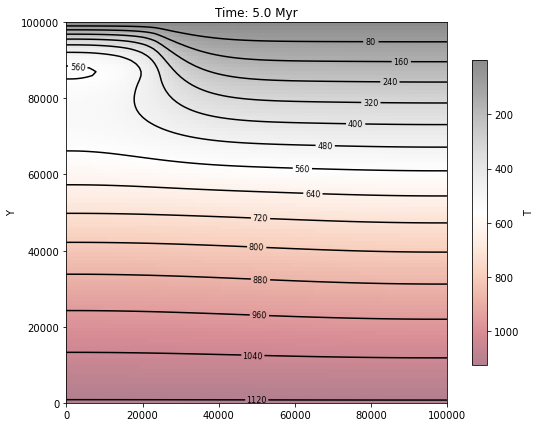

In [57]:
age=5.0 #Myr
lb_s = pLB.update_time(age,lb_s)
print(lb_s['mstep'])

mstep=lb_s['mstep']

#Reinitialise time
T = T_init

# Now we may begin our simulation time loop


timesteps = dt*np.arange(1,mstep+1,1)
for t in timesteps:
    lb_s['T']=T
    lb_s['f']=f
    lb_s =  pLB.LB_D2Q9_T(lb_s)
    T=lb_s['T']
    f=lb_s['f']
   
# And plot the result
plt.figure(figsize=(9,7))
plt.tight_layout()
con1 = plt.contour(X,Y,T,15,colors='black')
plt.clabel(con1,inline=True,fontsize=8)
plt.ylabel("Y")
plt.title("Time: {} Myr".format(age))
plt.imshow(T.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
#plt.colorbar();
cbar=plt.colorbar(label='T',shrink=0.8);
cbar.ax.invert_yaxis() 

# Plotting a timeseries

Lastly, we can call a plotting function within a time loop, and create a series of images showing the cooling of the pluton at different times.

1.0
2.0
5.0
20.0


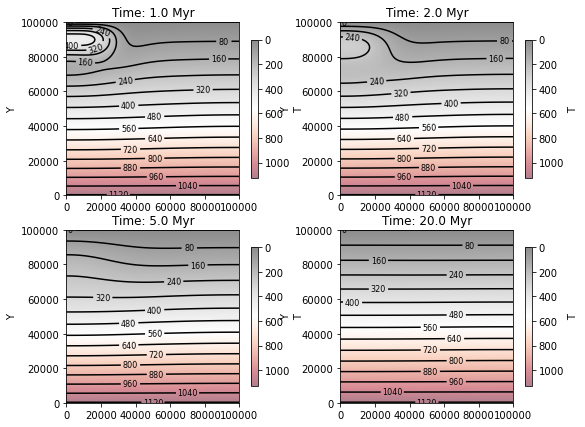

In [58]:
# Define a plotting routine

def plot_results(lb_s,i,ages):
    plt.subplot(2,2,i+1)
    X = lb_s['x']
    Y = lb_s['y']
    T = lb_s['T']
    n = lb_s['n']
    m = lb_s['m']
    dx = lb_s['dx']
    dy = lb_s['dy']
    con1 = plt.contour(X,Y,T,15,colors='black')
    plt.clabel(con1,inline=True,fontsize=8)
    plt.ylabel("Y")
    plt.title("Time: {} Myr".format(ages[i]))
    plt.imshow(T.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
    cbar=plt.colorbar(label='T',shrink=0.8);
    cbar.ax.invert_yaxis() 
    
# Configure the plot
plt.figure(figsize=(9,7))
plt.tight_layout()


ages=[1.0, 2.0, 5.0, 20.0] #Myr

# We want to loop over all 20Myrs, and just output on the way
age=20.0 #Myr
lb_s = pLB.update_time(age,lb_s)
mstep=lb_s['mstep']

# Reinitialise the simulation
T= T_init
lb_s['H']=0

# Now we may begin our simulation time loop
i=0
timesteps = dt*np.arange(1,mstep+1,1)
for t in timesteps:
    lb_s['T']=T
    lb_s['f']=f
    lb_s =  pLB.LB_D2Q9_T(lb_s)
    T=lb_s['T']
    f=lb_s['f']
    if t/M2S >= ages[i]:
        print(ages[i])
        plot_results(lb_s,i,ages)
        i +=1
    
   

